# cTRF_toolbox demo

Mikolaj Kegler

Contact: mikolaj.kegler16@imperial.ac.uk

Imperial College London, 20.05.2018

Example use of python implementation of the complex TRF modelling (cTRF) toolbox developed and applied in [Etard, et. al., 2018].

To download the sample data that can be processed with this script please use the following link: https://imperiallondon-my.sharepoint.com/:f:/g/personal/mak616_ic_ac_uk/En-V7CKltGdPqYKzd5xJ6a0BljqepRaHF-m9ta__LdtYhA?e=NgMXUv. The sample EEG and fundamental waveform data are the same as used in the paper and were obtained as described in the methods section.

Required packages to run this demo:

MNE https://martinos.org/mne/dev/index.html

NumPy http://www.numpy.org/

SciPy https://www.scipy.org/

Matplotlib https://matplotlib.org/

cTRF custom package (cTRF.py attached)

NOTE: The sample data are high-sampled and therefore fitting the complex backward models might require extensive amounts of RAM and might take a long time to compute. It is highly recommended to run this code on a computing cluster cluster or a specialized machine. On a PC-grade machine with a typical hardware specification (~8 gb RAM) we recommend running the complex forward models that are siginficantly 'lighter' in terms of number of parameters and required computational power.

Reference: Etard, O., Kegler, M., Braiman, C., Forte A.E., Reichenbach, T. (2018) 'Real-time decoding of selective attention from the human auditory brainstem response to continuous speech', doi: https://doi.org/10.1101/259853

In [1]:
import numpy as np
import mne
import cTRF
import matplotlib.pyplot as plt
import importlib
import os

In [2]:
# Load eeg data
eeg = mne.io.read_raw_fif('./eeg_short_raw.fif', preload=True)
eeg_data = eeg.get_data().T

# Load envelope data
FW = np.load('./FW_short.npy').T

# Choose regularization parameters to use in fitting the model
lambdas = [0,2,4,8,10]

# Choose range of time-lags considered in the model (in samples). 
# Those are time-lags of EEG data with respect to the stimulus.
tlag = [-10, 50] # In this example the EEG data is sampled at 1kHz, so latencies between -10 ms to 50 ms will be considered

Opening raw data file /home/mak616/Desktop/cTRF_develop/eeg_short_raw.fif...
    Range : 0 ... 338747 =      0.000 ...   338.747 secs
Ready.
Reading 0 ... 338747  =      0.000 ...   338.747 secs...


In [3]:
# Example use of train function from cTRF package to build a complex forward model
forward = cTRF.train(eeg_data, FW, tlag, forward=True, cmplx=True, lambdas=lambdas)

In [4]:
# To visualize the coefficients topography they should be reformatted. Here is how it can be done for the forward model.

n_timelags = tlag[1] - tlag[0] # Number of different timelags considered

# Real and imaginary parts of the forward model are extracted as Br and Bi, respectively (for all used regularization parameters - first dimension). 
Br = forward[:,:n_timelags,:] # First half of the columns correspond to real part of coefficients
Bi = forward[:,n_timelags:,:] # Seconda half of the columns correspond to imaginary part of coefficients

B_cmplx = Br + 1j*Bi # Both parts extracted above can be represented as complex numbers

# Next, the amplitude and phase of each complex coefficient is computed as Amp and Phi, respectively
Amp = np.abs(B_cmplx)
Phi = np.angle(B_cmplx)

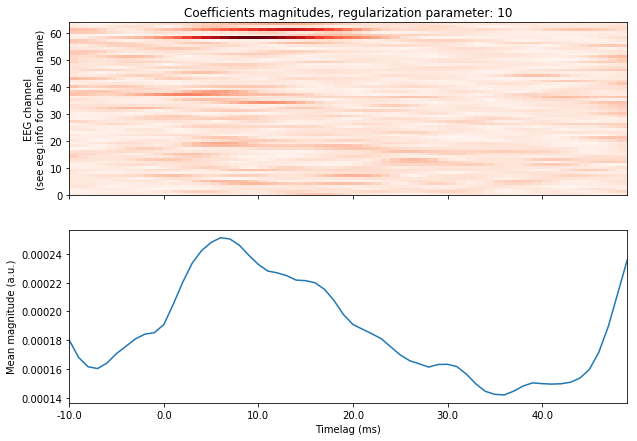

In [18]:
# Matrix representation of complex coefficients

f, (ax1, ax2) = plt.subplots(2,1,sharex=True)

f.set_figwidth(10)
f.set_figheight(7)

lmbd = 4 # Regularization parameter. Here with index 4.

ax1.pcolor(Amp[lmbd,:,:].T, cmap='Reds')
ax1.set_xlim(0,59)
ax1.set_ylabel('EEG channel\n(see eeg.info for channel name)')
ax1.set_title('Coefficients magnitudes, regularization parameter: {}'.format(lambdas[lmbd]))

ax2.plot(np.mean(Amp[lmbd,:,:], axis=1))
ax2.set_xlabel('Timelag (ms)')
ax2.set_xticklabels(ax2.get_xticks() + tlag[0])
ax2.set_ylabel('Mean magnitude (a.u.)')

plt.show(f)

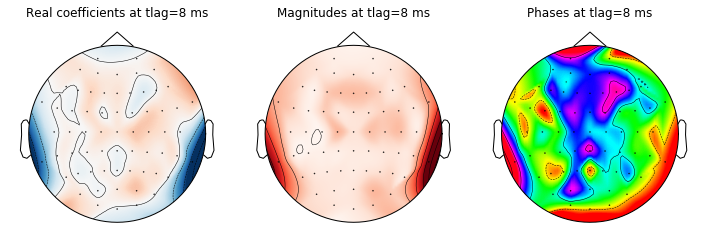

In [17]:
# Complex coefficients topographies

f, (ax1, ax2, ax3) = plt.subplots(1,3)

f.set_figwidth(10)

lmbd = 4 # Regularization parameter to be visualized

t = 18 # Timelag index (starting from -10 ms)

mne.viz.plot_topomap(B_cmplx.real[lmbd,t,:], eeg.info, axes=ax1, cmap='RdBu_r', show=False) # Visualize real parts at 10 ms latency
ax1.set_title('Real coefficients at tlag={} ms'.format(t + tlag[0]))
mne.viz.plot_topomap(Amp[lmbd,t,:], eeg.info, axes=ax2, cmap='Reds', show=False) # Visualize magnitudes at 10 ms latency
ax2.set_title('Magnitudes at tlag={} ms'.format(t + tlag[0]))
mne.viz.plot_topomap(Phi[lmbd,t,:], eeg.info, axes=ax3, cmap='hsv', show=False) # Visualize phases at 10 ms latency
ax3.set_title('Phases at tlag={} ms'.format(t + tlag[0]))

f.tight_layout()

plt.show(f)